## Import Statements

In [19]:
import copy

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [20]:
data = pd.read_json('../Data/data_impute.json')

# drop last row. only for use with data imputation!
data.drop(data.tail(1).index, inplace=True)

labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [21]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Feature Correlation

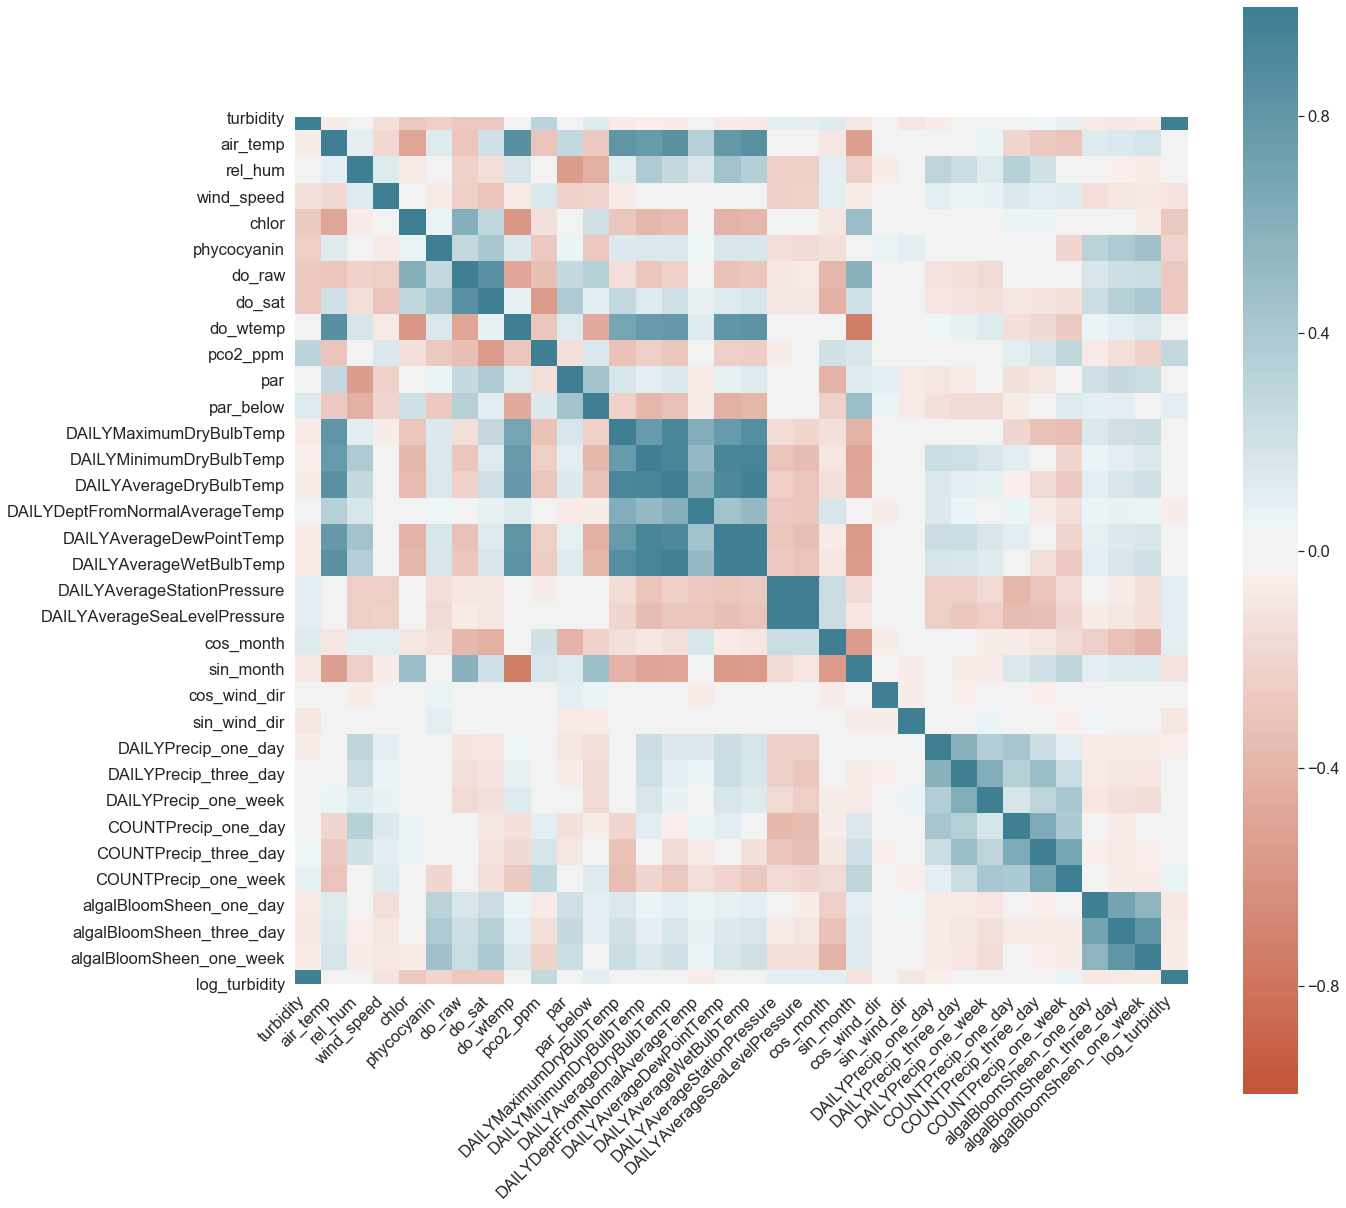

In [22]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Choose Correlated Features to Remove

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYMaximumDryBulbTemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 do_sat
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


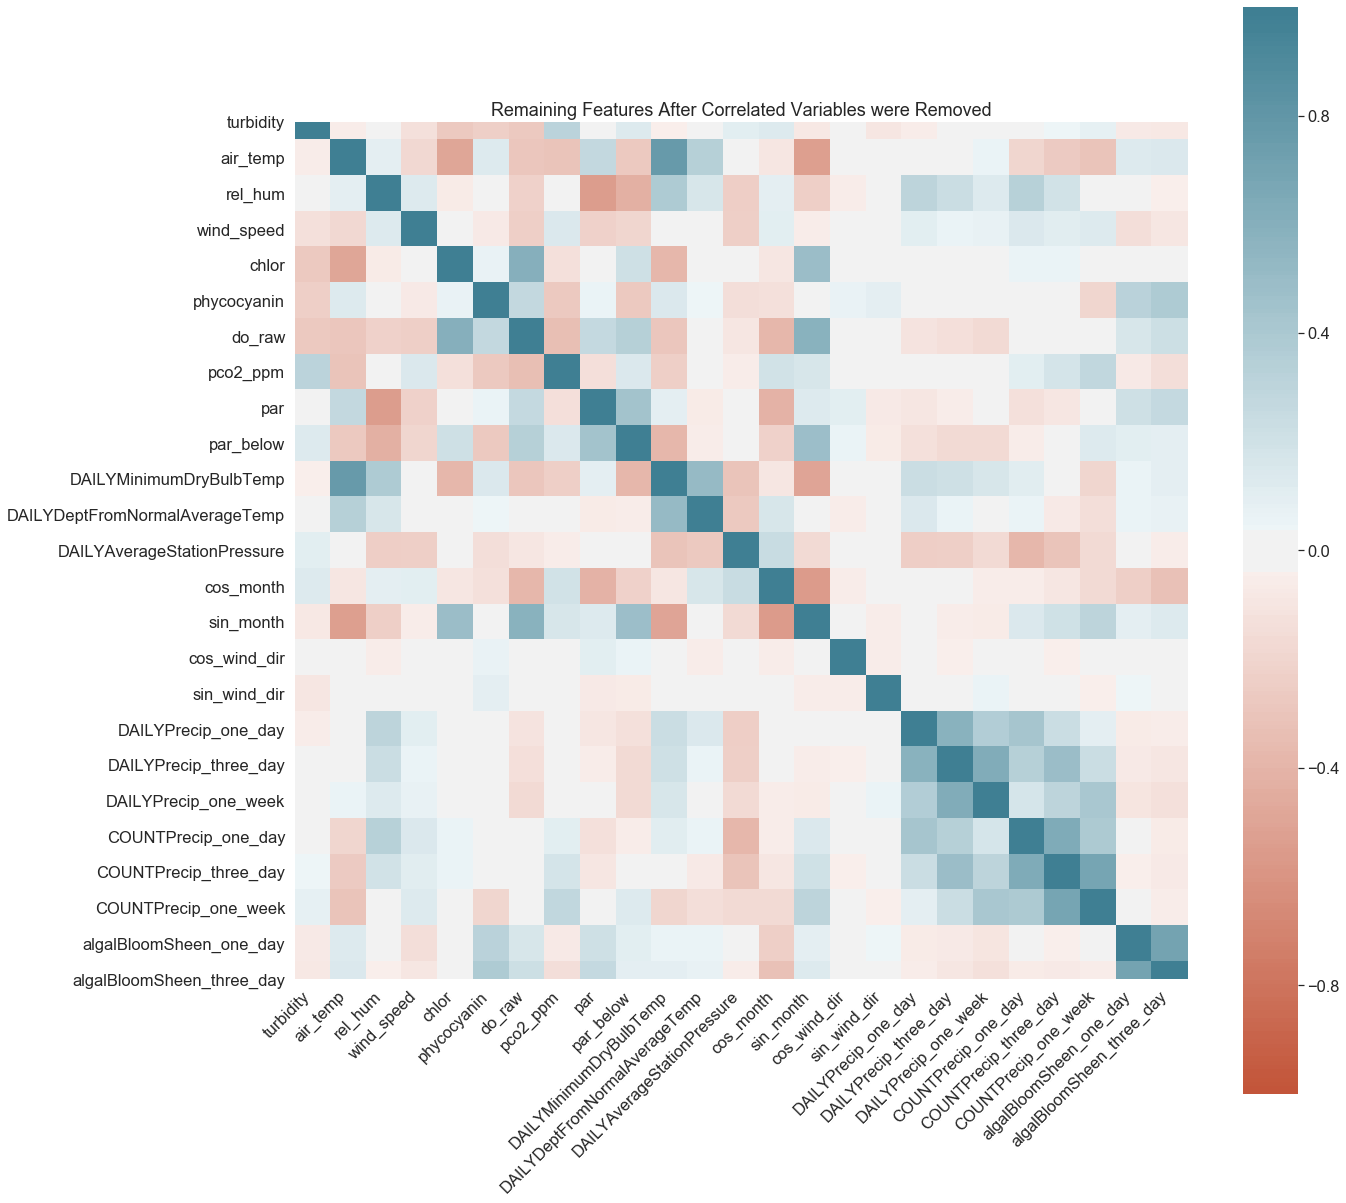

In [23]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])

new_corr = data[keep].corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

## Split Data

In [40]:
train_size = 0.7

df = data[keep]
# df = df[df.index > '2016']   # only keep data after 2015
# labels = labels.loc[df.index]

X_train, X_test, y_train, y_test = train_test_split(
    df.values,
    labels.values.ravel(),
    train_size=train_size,
    shuffle=True,
    stratify=labels.values.ravel()
)

### Impute Data

In [41]:
imp = IterativeImputer(max_iter=25, random_state=1337)

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

### Standardize data

In [42]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Define Model

In [43]:
rfc = RandomForestClassifier(
    n_estimators=10,
    max_depth=4,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced_subsample'   # balanced or balanced_subsample
)

## Evaluate

Accuracy: 0.7604
Balanced Accuracy: 0.7604
F1 Score: 0.3947
TPR: 0.4688
FPR: 0.1812

Confusion Matrix


,0,1
0,131,29
1,17,15


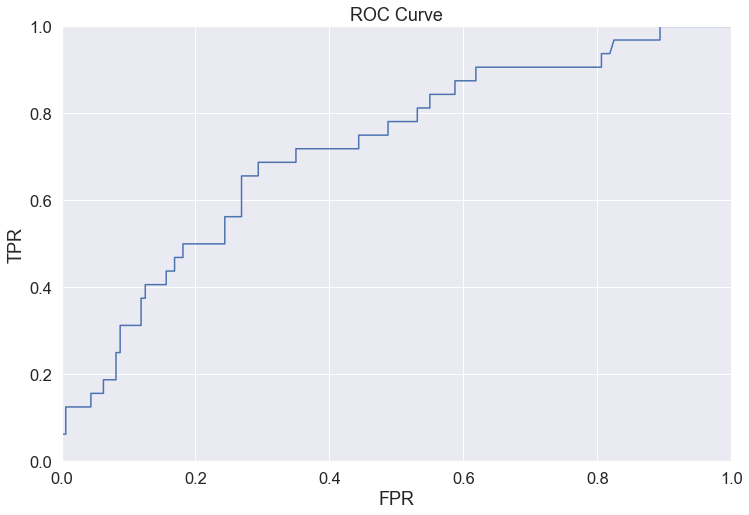

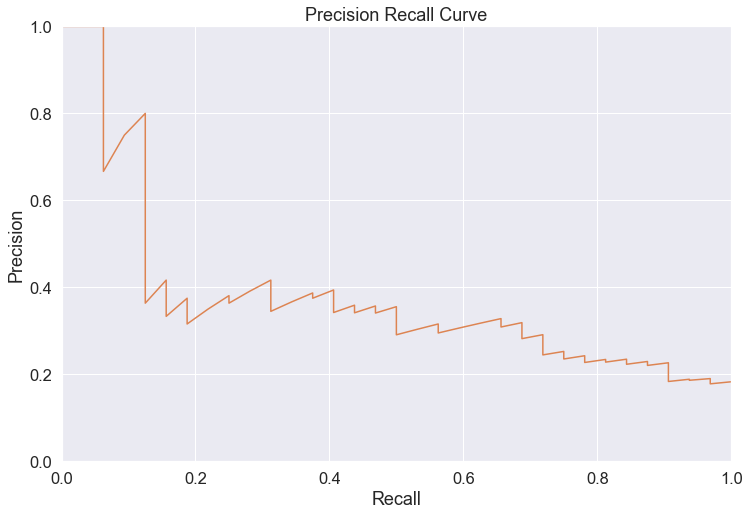

In [44]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('TPR: %0.4f' % (conf_matrix.iloc[1, 1] / (conf_matrix.iloc[1, 1] + conf_matrix.iloc[1, 0])))
print('FPR: %0.4f' % (conf_matrix.iloc[0, 1] / (conf_matrix.iloc[0, 1] + conf_matrix.iloc[0, 0])))
print('\nConfusion Matrix')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [46]:
coef_sort_idx = np.argsort(-np.abs(rfc.feature_importances_), kind='mergesort')

print('Feature weighting for Decision Trees with AdaBoost\n')
for idx in coef_sort_idx:
    coef = rfc.feature_importances_[idx]
    
    if coef < 0:
        print('\t%0.4f' % rfc.feature_importances_[idx], df.columns[idx])
    else:
        print('\t %0.4f' % rfc.feature_importances_[idx], df.columns[idx])

Feature weighting for Decision Trees with AdaBoost

	 0.1987 cos_month
	 0.1331 phycocyanin
	 0.0856 wind_speed
	 0.0674 do_raw
	 0.0534 sin_month
	 0.0530 algalBloomSheen_three_day
	 0.0460 chlor
	 0.0402 algalBloomSheen_one_day
	 0.0402 cos_wind_dir
	 0.0391 DAILYPrecip_one_day
	 0.0320 sin_wind_dir
	 0.0314 par_below
	 0.0310 DAILYMinimumDryBulbTemp
	 0.0295 rel_hum
	 0.0286 DAILYPrecip_three_day
	 0.0189 par
	 0.0172 pco2_ppm
	 0.0158 turbidity
	 0.0105 COUNTPrecip_one_week
	 0.0100 air_temp
	 0.0066 COUNTPrecip_three_day
	 0.0051 DAILYDeptFromNormalAverageTemp
	 0.0050 DAILYAverageStationPressure
	 0.0016 DAILYPrecip_one_week
	 0.0000 COUNTPrecip_one_day


## GridSearchCV

In [ ]:
rfc_params = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 2000],
    'criterion': ('gini', 'entropy'),
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'class_weight': ('balanced', 'balanced_subsample')
}

rfc_grid = GridSearchCV(
    estimator=rfc,
    param_grid=rfc_params,
    scoring='balanced_accuracy',    # or f1
    n_jobs=3,
    cv=5
)

rfc_grid.fit(X_train, y_train)

print('Best Random Forest Classifier:')
print(rfc_grid.best_params_)
print('Balanced Accuracy:', rfc_grid.best_score_)

In [ ]:
model = rfc_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [ ]:
coef_sort_idx = np.argsort(-np.abs(model.feature_importances_), kind='mergesort')

print('Feature weighting for Decision Trees with AdaBoost\n')
for idx in coef_sort_idx:
    coef = model.feature_importances_[idx]
    
    if coef < 0:
        print('\t%0.4f' % model.feature_importances_[idx], df.columns[idx])
    else:
        print('\t %0.4f' % model.feature_importances_[idx], df.columns[idx])